In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.3 MB/s eta 0:00:00


In [ ]:
# Load the dataset
import pandas as pd
file_path = "gene_expression.csv"  # Renamed Leukemia_GSE9476.csv as gene_expression.csv
data = pd.read_csv(file_path)


In [ ]:
# Understanding the dataset

#Examine the data types of each column
print("Datatype for each column")
print(data.dtypes)

#Check the shape of the dataset
print("\nShape of the dataset")
print(data.shape)

# Look for duplicate rows
print(f"Number of duplicate rows: {data.duplicated().sum()}")

Datatype for each column
samples              int64
type                object
1007_s_at          float64
1053_at            float64
117_at             float64
                    ...   
AFFX-ThrX-5_at     float64
AFFX-ThrX-M_at     float64
AFFX-TrpnX-3_at    float64
AFFX-TrpnX-5_at    float64
AFFX-TrpnX-M_at    float64
Length: 22285, dtype: object

Shape of the dataset
(64, 22285)
Number of duplicate rows: 0


In [6]:
# Importing all the required libraries
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.multiclass import OneVsOneClassifier
from pulp import LpProblem, LpMinimize, LpVariable, lpSum
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd


# Define the specified split
split_counts = {
    "Bone_Marrow_CD34": {"train": 5, "test": 3},
    "Bone_Marrow": {"train": 6, "test": 4},
    "AML": {"train": 16, "test": 10},
    "PB": {"train": 6, "test": 4},
    "PBSC_CD34": {"train": 6, "test": 4},
}

# Custom split based on the counts
train_data = []
test_data = []

for leukemia_type, counts in split_counts.items():
    group = data[data["type"] == leukemia_type]
    train_samples = group.sample(n=counts["train"], random_state=42)
    test_samples = group.drop(train_samples.index).sample(n=counts["test"], random_state=42)
    train_data.append(train_samples)
    test_data.append(test_samples)

train_data = pd.concat(train_data).reset_index(drop=True)
test_data = pd.concat(test_data).reset_index(drop=True)

# Extract features and labels for training and testing
X_train = train_data.drop(columns=["samples", "type"]).values
y_train = train_data["type"].values

X_test = test_data.drop(columns=["samples", "type"]).values
y_test = test_data["type"].values

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Feature Selection
feature_selector = SelectKBest(score_func=f_classif, k=9)
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_test_selected = feature_selector.transform(X_test)

# LP Binary Classifier
class LPBinaryClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        """
        Train the binary classifier using LP.
        """

        self.classes_ = np.unique(y)
        y_mapped = np.where(y == self.classes_[0], 1, -1)

        n_samples, n_features = X.shape
        self.weights_ = [LpVariable(f"w_{j}", lowBound=-50, upBound=50) for j in range(n_features)]
        self.bias_ = LpVariable("bias", lowBound=-50, upBound=50)
        slack = [LpVariable(f"slack_{i}", lowBound=0) for i in range(n_samples)]

        # LP Problem
        problem = LpProblem("Binary_Classification", LpMinimize)
        problem += lpSum(slack), "Minimize_Total_Slack"

        # Constraints
        for i in range(n_samples):
            margin = lpSum([self.weights_[j] * X[i, j] for j in range(n_features)]) + self.bias_
            if y_mapped[i] == 1:
                problem += margin >= 1 - slack[i], f"Constraint_pos_{i}"
            else:
                problem += margin <= -1 + slack[i], f"Constraint_neg_{i}"

        # Solve
        problem.solve()
        self.weights_ = np.array([w.varValue for w in self.weights_])
        self.bias_ = self.bias_.varValue
        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        scores = np.dot(X, self.weights_) + self.bias_
        return np.where(scores >= 0, self.classes_[0], self.classes_[1])

    def decision_function(self, X):
        """
        Calculates the diving line for seperating classes.
        """
        return np.dot(X, self.weights_) + self.bias_

# Train the OneVsOneClassifier with the custom binary LP classifier
ovo_classifier = OneVsOneClassifier(LPBinaryClassifier())
ovo_classifier.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = ovo_classifier.predict(X_test_selected)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)


Accuracy: 96.00%
Classification Report:
                   precision    recall  f1-score   support

             AML       0.91      1.00      0.95        10
     Bone_Marrow       1.00      1.00      1.00         4
Bone_Marrow_CD34       1.00      0.67      0.80         3
              PB       1.00      1.00      1.00         4
       PBSC_CD34       1.00      1.00      1.00         4

        accuracy                           0.96        25
       macro avg       0.98      0.93      0.95        25
    weighted avg       0.96      0.96      0.96        25



In [ ]:
# Get the indices of the selected features
selected_indices = feature_selector.get_support(indices=True)

# Extract the feature names (assuming your original feature names are stored in the columns of X_train)
feature_names = train_data.drop(columns=["samples", "type"]).columns

# Print the selected feature names
selected_feature_names = feature_names[selected_indices]
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['204007_at', '204749_at', '205950_s_at', '206522_at', '207008_at',
       '210119_at', '211163_s_at', '213122_at', '219672_at'],
      dtype='object')


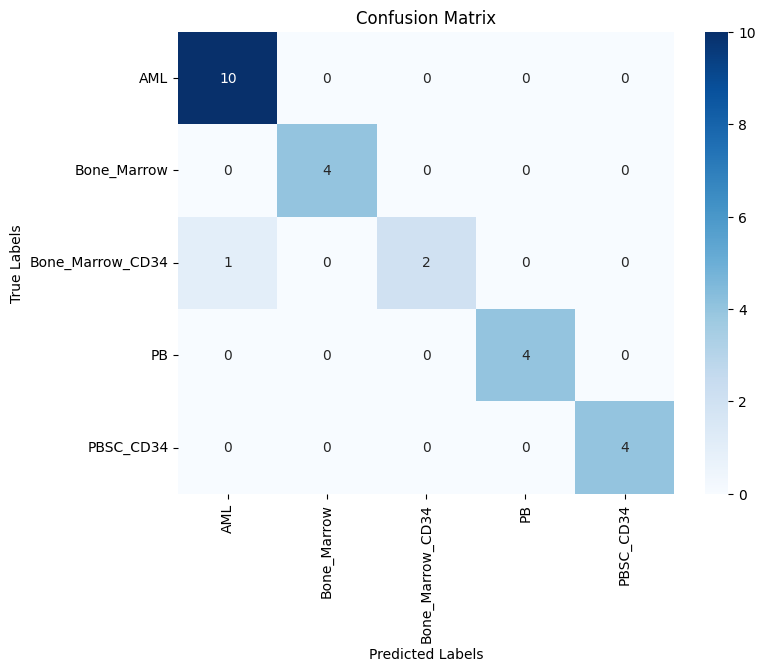

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()